<a href="https://colab.research.google.com/github/rymarinelli/Python/blob/master/Police_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!pip install pyspark 
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

     |████████████████████████████████| 204.7MB 59kB/s 
     |████████████████████████████████| 204kB 42.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=28be8a633b2e24bbbb7e1448cb1b203d54b2611b9bd3ccb461f3fbacf0e94d3c
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [3]:
import plotly.express as px
import pyspark.sql.functions as f
from pyspark.sql.functions import desc
from pyspark.sql.functions import col

In [4]:
file = "https://raw.githubusercontent.com/rymarinelli/Python/master/Tidy%20Tuesday/Data/allegations_202007271729.csv"

In [5]:
conf = SparkConf().setMaster("local").setAppName("Police_Analysis")
sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

In [6]:
df = pd.read_csv(file, error_bad_lines=False)
df.to_csv("data.csv")

In [7]:
df = sqlContext.read.csv("/content/data.csv", header= True)

In [8]:
# month and year 
# rank_now
# rank_incident
# complainant_ethnicity
# complainant_gender
# allegation 
# board_disposition

# Questions 
# Are people getting promoted that have violated policy?
# Are there habitual offenders? 
# How does the board respond?
# Is the board more or less likely to substanitate a compliant based on gender or ethnicity of person giving the compliant. 
# How do rates of compliants vary over time? 



In [9]:
df = df.select("unique_mos_id", "rank_now","rank_incident","complainant_ethnicity","complainant_age_incident","complainant_gender","allegation","board_disposition")

In [10]:
habit = df.groupBy("unique_mos_id","allegation").count()
habit.agg({'count':'max'}).show()
habit.agg({'count':'mean'}).show()

+----------+
|max(count)|
+----------+
|        15|
+----------+

+------------------+
|        avg(count)|
+------------------+
|1.4538243626062324|
+------------------+



In [11]:
habit = habit.filter(habit[2] > 4)


In [12]:
df = habit.toPandas()
fig = px.box(df, y="count")
fig.show()

In [13]:
df.median()

unique_mos_id    19602.0
count                5.5
dtype: float64

The average of the total data is around 1.5. When you remove officers that have 4 or less, then the extremes become more pronounced. When removing the subset of officers with fewer compliants, the median becomes 5.5. 

In [14]:
habit = habit.filter(habit[2] > 10)
df = habit.toPandas()
fig = px.box(df, y="count")
fig.show()

(13, 3)

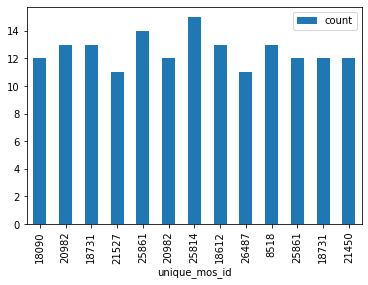

In [15]:
df.plot.bar(x = 'unique_mos_id', y = 'count' )
df.shape

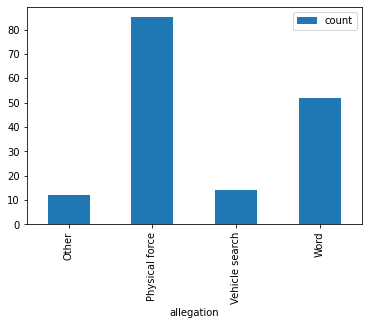

In [16]:
offencies = df.groupby('allegation').agg("sum")
offencies.plot.bar()

This group constitues the officers that have the most complaints issued against them. They also appear to be the most violent as physical force complaints vastly outnumber the others. 

In [17]:
id = df['unique_mos_id']
id = id.to_list()

In [18]:
df = sqlContext.read.csv("/content/data.csv", header= True)
df.select("unique_mos_id", "rank_now","rank_incident","complainant_ethnicity","complainant_age_incident","complainant_gender","allegation","board_disposition")

DataFrame[unique_mos_id: string, rank_now: string, rank_incident: string, complainant_ethnicity: string, complainant_age_incident: string, complainant_gender: string, allegation: string, board_disposition: string]

Filtering data to only officers that have the most complaints against them

In [19]:
problem = df.filter(f.col("unique_mos_id").isin(id))

In [20]:
 df_1 = problem.select("year_received","rank_incident","unique_mos_id")

 

In [21]:
minTest = df_1.sort("year_received", ascending = False).collect()
maxTest = df_1.sort("year_received", ascending = True).collect()


In [22]:

def orderFrame(list):
  values = []
  id = []

  for i in minTest:
    if (i[2] in id) is True:
      continue
    else:
      values.append(i)
      id.append(i[2])
  return sqlContext.createDataFrame(values)
 

In [23]:
minYear = orderFrame(minTest)
maxYear = orderFrame(maxTest)
minYear = minYear.withColumnRenamed("year_received", "start_year")
minYear = minYear.withColumnRenamed("rank_incident", "start_rank")
maxYear = maxYear.withColumnRenamed("year_received", "end_year")
maxYear = maxYear.withColumnRenamed("rank_incident", "end_rank")
minYear.show()
maxYear.show()

+----------+----------+-------------+
|start_year|start_rank|unique_mos_id|
+----------+----------+-------------+
|      2019| Inspector|        25814|
|      2019| Detective|        25861|
|      2019|  Sergeant|         8518|
|      2017|  Sergeant|        18090|
|      2017|  Sergeant|        21450|
|      2015| Detective|        20982|
|      2014|  Sergeant|        26487|
|      2013| Detective|        18612|
|      2012|Lieutenant|        18731|
|      2012|  Sergeant|        21527|
+----------+----------+-------------+

+--------+----------+-------------+
|end_year|  end_rank|unique_mos_id|
+--------+----------+-------------+
|    2019| Inspector|        25814|
|    2019| Detective|        25861|
|    2019|  Sergeant|         8518|
|    2017|  Sergeant|        18090|
|    2017|  Sergeant|        21450|
|    2015| Detective|        20982|
|    2014|  Sergeant|        26487|
|    2013| Detective|        18612|
|    2012|Lieutenant|        18731|
|    2012|  Sergeant|        21527|

In [24]:
df_2 = minYear.join(maxYear, on = "unique_mos_id", how = "inner")
over_time = df_2.groupBy("start_year").count()
over_time = over_time.sort("start_year", ascending = True).toPandas()




This plot is showing when officers started to turn bad essentially. This is picking up the first complaint officers had from the subset of officers that would excedded 10 complaints. The first officer to enter this cohort is from 2012. Officers that have left department have been removed from this data. But, it still does show two kinks. 2015 was when Black Lives Matter started to gain steam in Ferguson and may be reflected here. 


In [25]:
fig = px.line(over_time, x="start_year", y="count", title="Frequency of Problem Officers Entering Cohort of Problematic Officers")
fig.show()

In [26]:
df_2.show()

+-------------+----------+----------+--------+----------+
|unique_mos_id|start_year|start_rank|end_year|  end_rank|
+-------------+----------+----------+--------+----------+
|        25861|      2019| Detective|    2019| Detective|
|        21527|      2012|  Sergeant|    2012|  Sergeant|
|        25814|      2019| Inspector|    2019| Inspector|
|        26487|      2014|  Sergeant|    2014|  Sergeant|
|        21450|      2017|  Sergeant|    2017|  Sergeant|
|        18731|      2012|Lieutenant|    2012|Lieutenant|
|        20982|      2015| Detective|    2015| Detective|
|        18090|      2017|  Sergeant|    2017|  Sergeant|
|         8518|      2019|  Sergeant|    2019|  Sergeant|
|        18612|      2013| Detective|    2013| Detective|
+-------------+----------+----------+--------+----------+



It appears the people with the most complaints are the people with the most experience. 

In [27]:
first = df.filter(f.col("unique_mos_id").isin("25861"))
first.f.col


AttributeError: ignored

In [ ]:
df.filter(f.col("unique_mos_id").isin("25861")).show()